# Data profiling

In [2]:
from support_functions import log_progress, clean_drugbank, query_chembl
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy

## 0. Lookup known targets

In [5]:
# load perturbation info
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
all_pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)

In [6]:
# lookup cpd inchi keys
all_cpd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_cp']
all_cpd_inchis = all_cpd_pert_info[['pert_id','inchi_key']].set_index('pert_id').copy()
# remove duplicates, store as series
all_cpd_inchis = all_cpd_inchis[~all_cpd_inchis.index.duplicated()].inchi_key

### 0a. Lookup Drugbank targets

In [5]:
# lookup and store drugbank targets as dictionary: { inchi: [targets]}
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

KeyboardInterrupt: 

In [ ]:
# save to file
filename = 'checkpoint_files/drugbank_target_dict.sav'
pickle.dump(drugbank_target_dict, open(filename, 'wb'))

### 0b. Lookup Chembl targets

In [ ]:
# lookup and store chembl targets as dictionary: { inchi: [targets]}
chembl_target_dict = {}
tested_inchis = [] # b/c this bitch keeps crashing

In [ ]:
# query CHEMBL API using cpd inchi_keys to find human targets
for inchi in log_progress(all_cpd_inchis.values, every=2):
    if inchi not in tested_inchis:
        human_target_genes = query_chembl(inchi)
        if len(human_target_genes) > 0:
            chembl_target_dict[inchi] = human_target_genes
        tested_inchis.append(inchi)

In [ ]:
# save to file
filename = 'checkpoint_files/chembl_target_dict.sav'
pickle.dump(chembl_target_dict, open(filename, 'wb'))

### 0c. Combine targets

In [3]:
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

combined_target_dict = drugbank_target_dict.copy()
for cpd, chembl_targets in log_progress(chembl_target_dict.items()):
    try:
        drugbank_targets = drugbank_target_dict[cpd]
        combined_targets = list(set().union(chembl_targets,drugbank_targets))
        combined_target_dict[cpd] = combined_targets
    except KeyError:
        combined_target_dict[cpd] = chembl_targets

## 1. Identify cpd-KD pairs (pair set 1)

The first of several filtering steps, this set is composed of pairs of known cpd-target interactions where both the cpd and the target KD have been tested in at least one LINCS experiment.

In [7]:
all_kd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_sh']
kd_genes = all_kd_pert_info.pert_iname.unique()
len(kd_genes)

4371

In [8]:
cpd_1_, target_1_, label_1_ = [], [], []
for index, row in log_progress(all_cpd_pert_info.iterrows(), every=1):
    inchi = row.inchi_key
    
    # if the cpd has targets
    if inchi in combined_target_dict.keys():
        pert_id = row.pert_id
        targets = combined_target_dict[inchi]
        
        # add targets as positive examples
        for target in targets:
            if target in kd_genes:
                cpd_1_.append(pert_id)
                target_1_.append(target)
                label_1_.append(1)
                
        # add non-targets as negative examples
        for gene in kd_genes:
            if gene not in targets:
                cpd_1_.append(pert_id)
                target_1_.append(gene)
                label_1_.append(0)
                
    # if the compound has no targets
    else:
        pert_id = row.pert_id
        for gene in kd_genes:
            cpd_1_.append(pert_id)
            target_1_.append(gene)
            label_1_.append(0)

In [9]:
pair_set_1_df = pd.DataFrame({'cpd': cpd_1_, 'target': target_1_, 'label': label_1_})

In [10]:
print('Pair set 1 statistics\n')
print('No. True interactions:\t', pair_set_1_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_1_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_1_df[pair_set_1_df.label == 0].target.unique()))

Pair set 1 statistics

No. True interactions:	 4220
No. True cpds:		 1076
No. True genes:		 624

No. False interactions:	 97071332
No. False cpds:		 21299
No. False genes:	 4371


## 2. Identify same-cell cpd-KD pairs (pair set 2)

The second of several filtering steps, here we filter out cpd-KD pairs that have not both been tested in at least one common cell line.

### 2a. Signature quality filter

This step of finding common cells for all 100 million potential cpd-kd pairs is very slow. To speed things up we'll apply the signature quality filter here, rather than later on in the pipeline. We'll also store the high-quality signatures in dictionaries so that we can look them up quickly.

In [11]:
# load the signature information
all_sig_info = pd.DataFrame.from_csv('checkpoint_files/all_sig_info.csv')
all_cpd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_cp'].copy()
all_kd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_sh'].copy()

/Users/Nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

# filter the data
good_cpd_sig_info = all_cpd_sig_info[(all_cpd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                     (all_cpd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()
good_kd_sig_info = all_kd_sig_info[(all_kd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                   (all_kd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()

In [17]:
# create a dictionary of the good signatures so we can 
# look them up quickly by cpd/kd
good_cpds = set(good_cpd_sig_info.pert_id.unique())
good_cpd_sig_info_dict = {}
for cpd in log_progress(good_cpds):
    good_cpd_sig_info_dict[cpd] = good_cpd_sig_info[good_cpd_sig_info.pert_id == cpd].copy()
    
good_kds = set(good_kd_sig_info.pert_iname.unique())
good_kd_sig_info_dict = {}
for kd in log_progress(good_kds):
    good_kd_sig_info_dict[kd] = good_kd_sig_info[good_kd_sig_info.pert_iname == kd].copy()

In [14]:
# select representative sigs for good cpds
repr_cpd_sig_info_dict = {}
for cpd, good_sig_df in log_progress(good_cpd_sig_info_dict.items()):
    repr_cpd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_cpd_sig_info_dict[cpd] = repr_cpd_sigs_df

# select representative kd sigs for good kds
repr_kd_sig_info_dict = {}
for kd, good_sig_df in log_progress(good_kd_sig_info_dict.items()):
    repr_kd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_kd_sigs_df = repr_kd_sigs_df.append(repr_sig)
    repr_kd_sig_info_dict[kd] = repr_kd_sigs_df

### 2b. Identify pairs w/ high quality sigs (both cpd and kd)

In [ ]:
cpd_2_, target_2_, label_2_, common_cells_2_ = [], [], [], []

for index, row in log_progress(pair_set_1_df.iterrows(), every=5000):

    # bookmark to (hopfeully) save time
    curr_cpd = ''
    curr_cpd_sigs_df = ''
    curr_cpd_cells = ''
    
    # extract signatures
    cpd = row.cpd
    if cpd in good_cpds:
        target = row.target
        if target in good_kds: 
            
            # check if we need to load data for new cpd
            if not cpd == curr_cpd:
                curr_cpd = cpd
                curr_cpd_sigs_df = repr_cpd_sig_info_dict[curr_cpd]
                curr_cpd_cells = set(curr_cpd_sigs_df.cell_id.unique())
            
            # load data for target
            kd_sigs = repr_kd_sig_info_dict[target]
            kd_cells = set(kd_sigs.cell_id.unique())
            
            # compare cell lines
            common_cells = curr_cpd_cells & kd_cells
            if len(common_cells) > 0:
                cpd_2_.append(cpd)
                target_2_.append(target)
                label_2_.append(row.label)
                common_cells_2_.append(common_cells)

In [ ]:
pair_set_2_df = pd.DataFrame({'cpd': cpd_2_, 'target': target_2_, 'label': label_2_})
pair_set_2_df.to_csv('checkpoint_files/pair_set_2_df.csv')

In [ ]:
print('Pair set 2 statistics\n')
print('No. True interactions:\t', pair_set_2_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_2_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_2_df[pair_set_2_df.label == 0].target.unique()))

## 3. Identify cpd-KD pairs with interaction partners (pair set 3)

The third of several filtering steps, here we filter out cpd-KD pairs for which we do not know any interaction partners for the target.

In [ ]:
# load STRING 4.0 database
# 355319.0 high confidence interactions for 14893 genes
string_gene_interactions_700 = pd.DataFrame.from_csv('checkpoint_files/string_gene_interactions_700.csv')
string_genes = set(string_gene_interactions_700.gene_1.unique())

In [ ]:
# convert string interactions to dictionary of sets for fast lookup
string_interactions_dict = {}
for gene in log_progress(string_genes):
    partners = string_gene_interactions_700[string_gene_interactions_700.gene_1 == target].gene_2
    string_interactions_dict[gene] = set(partners)

In [ ]:
cpd_3_, target_3_, label_3_, common_cells_3_ = [], [], [], []

for index, row in log_progress(pair_set_2_df.iterrows(), every=100):
    if row.target in string_genes:
        cpd_3_.append(row.cpd)
        target_3_.append(row.target)
        label_3_.append(row.label)
        common_cells_3_.append(common_cells_2_[index])

In [ ]:
pair_set_3_df = pd.DataFrame({'cpd': cpd_3_, 'target': target_3_, 'label': label_3_})
pair_set_3_df.to_csv('checkpoint_files/pair_set_3_df.csv')

In [ ]:
print('Pair set 3 statistics\n')
print('No. True interactions:\t', pair_set_3_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_3_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_3_df[pair_set_3_df.label == 0].target.unique()))

## 4. Identify cpd-KD pairs with same-cell interaction partner KDs (pair set 4)

The fourth of several filtering steps, here we filter out cpd-KD pairs for which the target's interaction partners were not knocked down in any of the same cells as the cpd-target pair

In [ ]:
cpd_4_, target_4_, common_cells_4_, common_partners_4_ = [], [], [], []

for index, row in log_progress(pair_set_3_df.iterrows(), every=100):
    common_cells = common_cells_3_[index]
    target = row.target
    common_partners_dict = {}
    
    # find interaction partner signatures
    partners = string_interactions_dict[target]
    partner_sigs = pd.concat([ repr_kd_sig_info_dict[p] for p in partners ], ignore_index=True)
    
    print(partner_sigs)
    break
    
    # repr_kd_sig_info_dict[target]
    #partner_sigs = all_kd_sig_info[all_kd_sig_info.pert_iname.isin(partners)]
    
    # group by cell line
    for cell_line in common_cells:
        partner_cell_sigs = partner_sigs[partner_sigs.cell_id == cell_line]
        cell_partners = partner_cell_sigs.pert_iname.unique()
        if len(cell_partners) > 0:
            # store in dictionary
            common_partners_dict[cell_line] = cell_partners
    
    # make sure we have partner KDs in at least one cell line
    if len(common_partners_dict.keys()) > 0:
        common_cells_4 = set(common_partners_dict.keys())
        cpd_4_.append(row.cpd)
        target_4_.append(target)
        common_cells_4_.append(common_cells_4)
        common_partners_4_.append(common_partners_dict)

In [ ]:
pair_set_4_df = pd.DataFrame({'cpd': cpd_4_, 'target': target_4_})
print('Pair set 4 statistics')
print('No. unique cpds:\t', len(pair_set_4_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_4_df.target.unique()))
print('No. interactions:\t', pair_set_4_df.shape[0])

## 5. Signature quality of cpd (pair set 5)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the cpd in the pair. Next we'll enforce the same signature quality requirements on the KD and the interaction partners.

In [ ]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

In [ ]:
cpd_5_, target_5_, common_cells_5_, common_partners_5_ = [], [], [], []

for index, row in log_progress(pair_set_4_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_4_[index]
    
    # new common cells and partners after filtering
    common_cells_5 = set()
    common_partners_dict_5 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        cpd_cell_sigs = all_cpd_sig_info[(all_cpd_sig_info.pert_id == cpd) &
                                         (all_cpd_sig_info.cell_id == cell_line)]
        good_cpd_cell_sigs = cpd_cell_sigs[(cpd_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                           (cpd_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality cpd sig
        if len(good_cpd_cell_sigs) > 0:
            common_cells_5.add(cell_line)
            common_partners_dict_5[cell_line] = common_partners_4_[index][cell_line]
        
    # if we have at least one good cell line for the cpd
    if len(common_cells_5) > 0:
        cpd_5_.append(cpd)
        target_5_.append(target)
        common_cells_5_.append(common_cells_5)
        common_partners_5_.append(common_partners_dict_5)

In [ ]:
pair_set_5_df = pd.DataFrame({'cpd': cpd_5_, 'target': target_5_})
print('Pair set 5 statistics')
print('No. unique cpds:\t', len(pair_set_5_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_5_df.target.unique()))
print('No. interactions:\t', pair_set_5_df.shape[0])

## 6. Signature quality of KD (pair set 6)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the KD in the pair. Next we'll enforce the same signature quality requirements on the interaction partners.

In [ ]:
cpd_6_, target_6_, common_cells_6_, common_partners_6_ = [], [], [], []

for index, row in log_progress(pair_set_5_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_5_[index]
    
    # new common cells and partners after filtering
    common_cells_6 = set()
    common_partners_dict_6 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        kd_cell_sigs = all_kd_sig_info[(all_kd_sig_info.pert_iname == target) &
                                       (all_kd_sig_info.cell_id == cell_line)]
        good_kd_cell_sigs = kd_cell_sigs[(kd_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                         (kd_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality kd sig
        if len(good_kd_cell_sigs) > 0:
            common_cells_6.add(cell_line)
            common_partners_dict_6[cell_line] = common_partners_5_[index][cell_line]
        
    # if we have at least one good cell line for the kd
    if len(common_cells_6) > 0:
        cpd_6_.append(cpd)
        target_6_.append(target)
        common_cells_6_.append(common_cells_6)
        common_partners_6_.append(common_partners_dict_6)

In [ ]:
pair_set_6_df = pd.DataFrame({'cpd': cpd_6_, 'target': target_6_})
print('Pair set 6 statistics')
print('No. unique cpds:\t', len(pair_set_6_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_6_df.target.unique()))
print('No. interactions:\t', pair_set_6_df.shape[0])

## 7. Signature quality of interaction partners (pair set 7)

Now we'll look at how the size of the training set changes as we place more stringent requirements on the quality of the expression signatures for the interaction partners of the target.

In [ ]:
cpd_7_, target_7_, common_cells_7_, common_partners_7_ = [], [], [], []

for index, row in log_progress(pair_set_6_df.iterrows(), every=1):
    cpd = row.cpd
    target = row.target
    common_cells = common_cells_6_[index]
    common_partners_dict = common_partners_6_[index]
    
    # new common cells and partners after filtering
    common_cells_7 = set()
    common_partners_dict_7 = {}
    
    # check if criteria are met in each cell line
    for cell_line in common_cells:
        cell_partners = common_partners_dict[cell_line]
        partner_cell_sigs = all_kd_sig_info[(all_kd_sig_info.pert_iname.isin(cell_partners)) &
                                            (all_kd_sig_info.cell_id == cell_line)]
        good_partner_cell_sigs = partner_cell_sigs[(partner_cell_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                                   (partner_cell_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        
        # if the cell line has at least one high quality partner sig
        if len(good_partner_cell_sigs) > 0:
            common_cells_7.add(cell_line)
            good_partners = good_partner_cell_sigs.pert_iname.unique()
            common_partners_dict_7[cell_line] = good_partners
        
    # if we have at least one good cell line for the cpd
    if len(common_cells_7) > 0:
        cpd_7_.append(cpd)
        target_7_.append(target)
        common_cells_7_.append(common_cells_7)
        common_partners_7_.append(common_partners_dict_7)

In [ ]:
pair_set_7_df = pd.DataFrame({'cpd': cpd_7_, 'target': target_7_})
print('Pair set 7 statistics')
print('No. unique cpds:\t', len(pair_set_7_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_7_df.target.unique()))
print('No. interactions:\t', pair_set_7_df.shape[0])

In [ ]:
# save to file
pickle.dump(pair_set_7_df, open('checkpoint_files/pair_set_7_df.sav', 'wb'))
pickle.dump(common_cells_7_, open('checkpoint_files/common_cells_7_.sav', 'wb'))
pickle.dump(common_partners_7_, open('checkpoint_files/common_partners_7_', 'wb'))

## Cell count anaylsis

In [12]:
# load filtered data
pair_set_7_df = pickle.load(open('checkpoint_files/pair_set_7_df.sav', 'rb'))
common_cells_7_ = pickle.load(open('checkpoint_files/common_cells_7_.sav', 'rb'))
common_partners_7_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

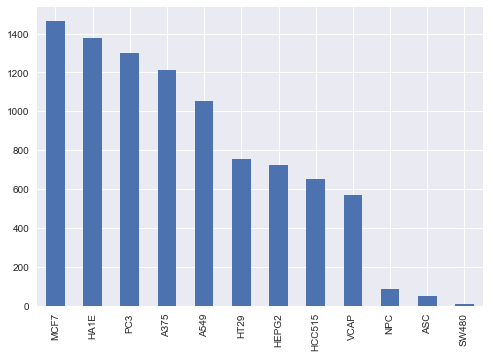

In [13]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in common_cells_7_ ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

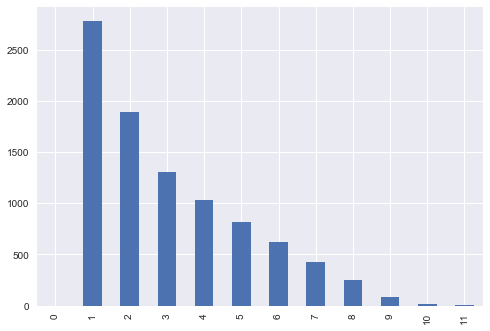

In [14]:
# how many pairs tested in at least n cell lines?
num_common_cells_7 = np.array([ len(cells) for cells in common_cells_7_])
pair_set_7_df['ncells'] = num_common_cells_7
ncell_counts = pair_set_7_df.ncells.value_counts()
cum_ncell_counts = [0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.show()

## 8. Most common cell lines (pair set 8)
Three of the cell lines have very few drugs. We can ignore them and just focus on data from the 9 most common cell lines.

In [15]:
top_9_cell_lines = set(cell_line_counts.index[:9])

In [16]:
# filter out pairs not in the top-9 cell lines
cpd_8_, target_8_, common_cells_8_, common_partners_8_ = [], [], [], []

for index, row in log_progress(pair_set_7_df.iterrows(), every=1):
    common_cells = common_cells_7_[index]
    top_common_cells = common_cells & top_9_cell_lines
    if len(top_common_cells) > 0:
        cpd_8_.append(row.cpd)
        target_8_.append(row.target)
        common_cells_8_.append(top_common_cells)
        
        common_partners = {}
        for c in top_common_cells:
            common_partners[c] = common_partners_7_[index][c]
        common_partners_8_.append(common_partners)

In [17]:
pair_set_8_df = pd.DataFrame({'cpd': cpd_8_, 'target': target_8_})
print('Pair set 8 statistics')
print('No. unique cpds:\t', len(pair_set_8_df.cpd.unique()))
print('No. unique KDs:\t\t', len(pair_set_8_df.target.unique()))
print('No. interactions:\t', pair_set_8_df.shape[0])

Pair set 8 statistics
No. unique cpds:	 628
No. unique KDs:		 453
No. interactions:	 2777


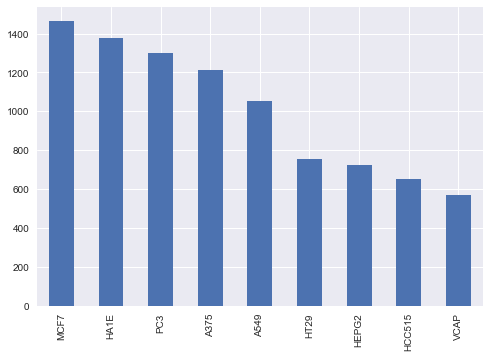

In [18]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in common_cells_8_ ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

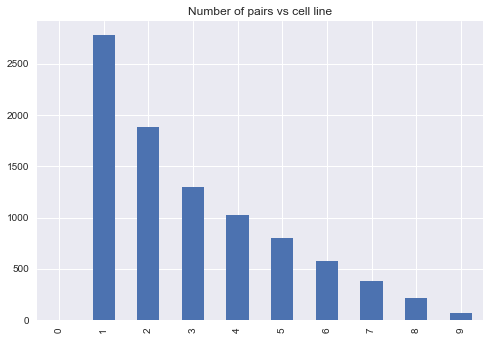

0       0
1    2777
2    1885
3    1303
4    1029
5     797
6     579
7     385
8     215
9      67
dtype: int64


In [19]:
# how many pairs tested in at least n cell lines?
num_common_cells_8 = np.array([ len(cells) for cells in common_cells_8_])
pair_set_8_df['ncells'] = num_common_cells_8
ncell_counts = pair_set_8_df.ncells.value_counts()
cum_ncell_counts = [0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.title('Number of pairs vs cell line')
plt.show()
print(cum_ncell_counts)

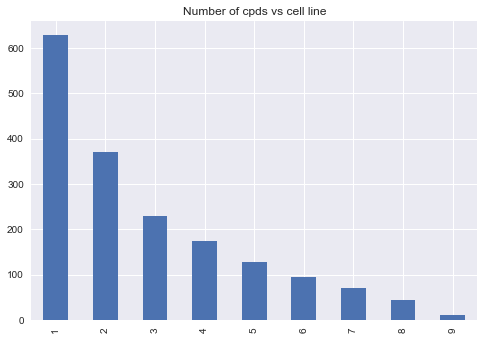

1    628.0
2    371.0
3    229.0
4    175.0
5    128.0
6     95.0
7     71.0
8     44.0
9     12.0
dtype: float64


In [20]:
cpd_counts = pd.Series(index=range(1,10))
for i in range(1,10):
    pairs = pair_set_8_df[pair_set_8_df.ncells >= i]
    ncpds = len(pairs.cpd.unique())
    cpd_counts[i] = ncpds
cpd_counts.plot.bar()
plt.title('Number of cpds vs cell line')
plt.show()
print(cpd_counts)

In [21]:
# save to file
pickle.dump(pair_set_8_df, open('checkpoint_files/pair_set_8_df.sav', 'wb'))
pickle.dump(common_cells_8_, open('checkpoint_files/common_cells_8_.sav', 'wb'))
pickle.dump(common_partners_8_, open('checkpoint_files/common_partners_8_', 'wb'))

___
# 9. Minimum of 3 common cell lines (pair set 9)

Many of our pairs are tested in only one or two cell lines. These are likely to be very hard to predict with. So, for now, we will only consider pairs with data from three or more common cell lines.

___
# Extract gene expression signatures

### Compounds

In [165]:
# load filtered data
pair_set_8_df = pickle.load(open('checkpoint_files/pair_set_7_df.sav', 'rb'))
common_cells_8_ = pickle.load(open('checkpoint_files/common_cells_7_.sav', 'rb'))
common_partners_8_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

In [200]:
# reference lists
top_9_cell_lines = list(top_9_cell_lines)
top_9_cell_line_cpds = pair_set_8_df.cpd.unique()
top_9_cell_line_targets = pair_set_8_df.target.unique()

gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [256]:
# extract cpd sigs
top_9_cpd_sigs = all_cpd_sig_info[(all_cpd_sig_info['cell_id'].isin(top_9_cell_lines)) &
                                  (all_cpd_sig_info['pert_id'].isin(top_9_cell_line_cpds))]

# select representatives
repr_top_9_cpd_sigs = pd.DataFrame(columns=top_9_cpd_sigs.columns)
for pert_id in log_progress(top_9_cell_line_cpds):
    for cell_id in top_9_cell_lines:
        candidate_sigs = top_9_cpd_sigs[(top_9_cpd_sigs.pert_id == pert_id) &
                                        (top_9_cpd_sigs.cell_id == cell_id)]
        good_candidate_sigs = candidate_sigs[(candidate_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                             (candidate_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        if len(good_candidate_sigs) > 0:
            repr_sig = good_candidate_sigs.loc[good_candidate_sigs['tas'].idxmax()]
            repr_top_9_cpd_sigs = repr_top_9_cpd_sigs.append(repr_sig)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [266]:
# extract the actual signatures
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_9_cpd_sigs.sig_id.values ]
phase_1_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_2_sig_ids ]

# extract the actual signatures
phase_1_top_9_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_9_cpd_raw_sigs = pd.concat([phase_1_top_9_cpd_sigs, phase_2_top_9_cpd_sigs], axis=1)

# discard all but landmark gene values
top_9_cpd_lm_sigs = top_9_cpd_raw_sigs[top_9_cpd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_cpd_lm_sigs = top_9_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_cpd_lm_sigs.head()

cid,CPC004_A375_6H:BRD-K89997465-001-05-3:10,CPC004_A375_6H:BRD-A69815203-001-05-0:10,CPC005_A375_6H:BRD-A47494775-003-03-0:10,CPC005_A375_6H:BRD-K63630713-001-15-9:10,CPC005_A375_6H:BRD-K64755930-003-02-4:10,CPC004_A375_6H:BRD-A97104540-004-08-5:10,CPC004_A375_6H:BRD-K09602097-001-04-5:10,CPC005_A375_6H:BRD-K65146499-001-14-7:10,CPC005_A375_6H:BRD-K50836978-001-01-7:10,CPC005_A375_6H:BRD-K51465424-003-03-6:10,...,LJP009_PC3_24H:E21,LJP009_PC3_24H:G18,LJP009_PC3_24H:L09,LPROT001_A375_6H:L01,LPROT001_MCF7_6H:K01,LPROT001_PC3_6H:H18,LPROT002_MCF7_6H:H20,REP.A026_HA1E_24H:C09,REP.A026_HA1E_24H:D10,REP.A026_HA1E_24H:F03
10007,0.246128,-0.884828,-2.406841,-0.276369,-2.673422,-0.660713,-0.764945,0.319655,-3.253649,-0.213951,...,0.968474,-0.510815,-0.087325,-0.1917,-0.9115,-3.5535,-0.9865,-0.002179,-0.405487,-0.058607
1001,0.004896,-0.062786,1.795862,-0.982720,-0.629860,-0.527487,-0.819784,-1.175159,3.122064,-0.681915,...,0.481926,-1.340263,0.046377,0.0650,-0.5532,-0.1200,-0.9039,1.141393,-0.510453,0.887252
10013,0.165795,-0.539606,1.765759,0.091157,1.409056,0.413121,0.203825,-0.183082,-0.716842,0.392804,...,0.648107,0.589351,-0.803818,0.5969,-0.8921,-3.4834,-0.1152,-0.215681,-0.234399,0.645195
10038,-0.208777,-0.727963,-1.403634,0.701902,1.469781,1.332837,1.471901,0.336726,-2.547382,0.862813,...,0.676413,-1.309107,-0.803498,5.8980,2.0580,1.0855,0.2946,-0.310775,0.206856,-0.125399
10046,0.105232,-0.086188,0.449683,-0.555949,-0.310975,-0.316771,0.006420,-0.210040,2.728706,0.862758,...,-0.763923,-0.448527,-0.566167,-2.3078,1.1517,-1.2228,0.3952,4.949234,-0.123612,3.239362


In [216]:
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)
repr_top_9_cpd_sigs.to_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs.to_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')

(1830, 15)
(978, 1830)


### Knockdowns

In [213]:
# extract KD sigs
top_9_kd_sigs = all_kd_sig_info[(all_kd_sig_info['cell_id'].isin(top_9_cell_lines))]
top_9_cell_line_kds = top_9_kd_sigs.pert_iname.unique()

# select representatives
repr_top_9_kd_sigs = pd.DataFrame(columns=top_9_kd_sigs.columns)
for pert_iname in log_progress(top_9_cell_line_kds, every=1):
    for cell_id in top_9_cell_lines:
        candidate_sigs = top_9_kd_sigs[(top_9_kd_sigs.pert_iname == pert_iname) &
                                       (top_9_kd_sigs.cell_id == cell_id)]
        good_candidate_sigs = candidate_sigs[(candidate_sigs.distil_cc_q75 >= distill_cc_cutoff) &
                                             (candidate_sigs.pct_self_rank_q25 <= pct_self_rank_cutoff)]
        if len(good_candidate_sigs) > 0:
            repr_sig = good_candidate_sigs.loc[good_candidate_sigs['tas'].idxmax()]
            repr_top_9_kd_sigs = repr_top_9_kd_sigs.append(repr_sig)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [238]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_9_kd_sigs.sig_id.values ]

# read in the data
top_9_kd_raw_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=top_9_kd_sig_ids).data_df

# discard non-landmark gene expression scores
top_9_kd_lm_sigs = top_9_kd_raw_sigs[top_9_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_kd_lm_sigs = top_9_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_kd_lm_sigs.head()

cid,DER001_A375_96H:TRCN0000197159:-666,DER001_A375_96H:TRCN0000006029:-666,DER001_A375_96H:TRCN0000338772:-666,DER001_A375_96H:TRCN0000218565:-666,DER001_A375_96H:TRCN0000369366:-666,DER001_A375_96H:TRCN0000138966:-666,DER001_A375_96H:TRCN0000262375:-666,DER001_A375_96H:TRCN0000141905:-666,DER001_A375_96H:TRCN0000350521:-666,DER001_A375_96H:TRCN0000051204:-666,...,KDB001_PC3_96H:TRCN0000343797:-666,KDB001_PC3_96H:TRCN0000319318:-666,KDB001_PC3_96H:TRCN0000323290:-666,KDB001_PC3_96H:TRCN0000159391:-666,KDB001_PC3_96H:TRCN0000364667:-666,KDB001_PC3_96H:TRCN0000135504:-666,KDB001_PC3_96H:TRCN0000142389:-666,KDB001_PC3_96H:TRCN0000180510:-666,KDB001_PC3_96H:TRCN0000254328:-666,KDB001_PC3_96H:TRCN0000133950:-666
rid,,,,,,,,,,,,,,,,,,,,,
10007,-1.582821,1.147524,-0.233997,0.705900,-0.493815,-0.215770,0.451134,-0.327473,-0.766019,2.288669,...,-0.39430,0.39255,0.40935,1.98080,0.46525,-0.81515,-0.31605,-0.02665,0.36655,1.32305
1001,-0.037421,1.322280,0.614880,-0.021201,1.828483,1.179174,-0.062841,0.722374,0.865695,0.364353,...,0.75325,-0.32005,-1.70935,0.82750,0.14065,-0.61405,-0.14040,0.64610,1.46140,0.01925
10013,0.156317,0.654752,1.081601,0.210859,0.883683,-0.093974,1.296774,-1.416878,-0.155374,-0.297705,...,-0.43025,-0.46250,-0.24895,0.34875,-0.56190,0.47240,-0.57825,-0.82385,0.35615,0.69620
10038,0.717362,0.046802,0.573958,-1.193527,-0.049510,0.716104,1.441153,-0.215514,0.236909,-1.513038,...,-0.14960,-0.22880,0.61105,-2.17760,0.02495,0.22810,-1.60735,0.69330,-0.59275,-0.38195
10046,-0.171960,1.246416,4.340301,-0.888133,0.597416,1.460984,-1.016598,0.117003,0.889986,0.808288,...,-0.15285,-0.22195,-0.83325,0.00205,-1.43080,0.42020,-0.35985,0.94590,-0.75705,0.32970


In [239]:
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)
repr_top_9_kd_sigs.to_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs.to_csv('checkpoint_files/top_9_kd_lm_sigs.csv')

(30323, 15)
(978, 30323)


___
## Feature construction

In [240]:
# load data
pair_set_8_df = pickle.load(open('checkpoint_files/pair_set_8_df.sav', 'rb'))
common_cells_8_ = pickle.load(open('checkpoint_files/common_cells_8_.sav', 'rb'))
common_partners_8_ = pickle.load(open('checkpoint_files/common_partners_8_', 'rb'))

repr_top_9_cpd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')
repr_top_9_kd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_kd_lm_sigs.csv')

### Labels

In [241]:
# create cpd-kd mapping with labels
all_top_9_kds = repr_top_9_kd_sigs.pert_iname.unique()
all_top_9_cpds = repr_top_9_cpd_sigs.pert_id.unique()
top_9_known_interactions = pair_set_8_df

cpd_, kd_, label_ = [], [], []
for kd in log_progress(all_top_9_kds, every=1):
    for cpd in all_top_9_cpds:
        if top_9_known_interactions.query('cpd == "{}" & target == "{}"'.format(cpd,kd)).shape[0]:
            label = 1 # true interaction
        else:
            label = -1 # false interaction
        cpd_.append(cpd)
        kd_.append(kd)
        label_.append(label)
                 
# store pairs & labels in dataframe
top_9_cpd_kd_pairs_df = pd.DataFrame({'cpd': cpd_, 'kd': kd_, 'label': label_})
top_9_cpd_kd_pairs_df.to_csv('features/top_9_cpd_kd_pairs_df.csv')

Widget Javascript not detected.  It may not be installed or enabled properly.


### Direct Correlation

In [277]:
# correlation computation is slow b/c we have to look up cpd/kd/cell specific signatures in 
# large dataframes with 30,000+ rows. We can perhaps speed this up if we create cell-line 
# specific dataframes
repr_top_9_cpd_sigs_dict = {}
top_9_cpd_lm_sigs_dict = {}
for cell_line in log_progress(top_9_cell_lines):
    cpd_sig_info = repr_top_9_cpd_sigs[repr_top_9_cpd_sigs.cell_id == cell_line].copy()
    repr_top_9_cpd_sigs_dict[cell_line] = cpd_sig_info
    sig_ids = cpd_sig_info.sig_id
    lm_sigs = top_9_cpd_lm_sigs[sig_ids].copy()
    top_9_cpd_lm_sigs_dict[cell_line] = lm_sigs

Widget Javascript not detected.  It may not be installed or enabled properly.


In [279]:
repr_top_9_kd_sigs_dict = {}
top_9_kd_lm_sigs_dict = {}
for cell_line in log_progress(top_9_cell_lines):
    kd_sig_info = repr_top_9_kd_sigs[repr_top_9_kd_sigs.cell_id == cell_line].copy()
    repr_top_9_kd_sigs_dict[cell_line] = kd_sig_info
    sig_ids = kd_sig_info.sig_id
    lm_sigs = top_9_kd_lm_sigs[sig_ids].copy()
    top_9_kd_lm_sigs_dict[cell_line] = lm_sigs

Widget Javascript not detected.  It may not be installed or enabled properly.


In [285]:
len(top_9_cpd_kd_pairs_df)

2721124

In [286]:
# initialize empty dataframe to hold direct correlation values
dir_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)

# loop through cpd-target pairs, calculate correlations in each cell line
for index, row in log_progress(top_9_cpd_kd_pairs_df.iterrows(), every=100):
    cpd = row.cpd
    kd = row.kd
    
    for cell_line in top_9_cell_lines:
        cpd_sig_info = repr_top_9_cpd_sigs_dict[cell_line].query('pert_id == "{}"'.format(cpd))
        kd_sig_info = repr_top_9_kd_sigs_dict[cell_line].query('pert_iname == "{}"'.format(kd))
        
        # remember we have missing data, not all pairs are tested in all cell lines
        if not (cpd_sig_info.empty or kd_sig_info.empty):
            # extract signatures
            cpd_sig_id = cpd_sig_info.sig_id
            kd_sig_id = kd_sig_info.sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs_dict[cell_line][cpd_sig_id].values
            kd_lm_sig = top_9_kd_lm_sigs_dict[cell_line][kd_sig_id].values
            #compute and store correlation
            corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
            dir_corr_df.at[index, cell_line] = corr

Widget Javascript not detected.  It may not be installed or enabled properly.


In [287]:
dir_corr_df.to_csv('features/top_9_dir_corr_df.csv')

### Indirect Correlation

In [ ]:
# list of all KDs in top-4 cells, for reference
all_kds = repr_top_9_kd_sigs.pert_iname.unique()

# initialize empty dataframe to hold direct correlation values
indir_max_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)
indir_min_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)
indir_avg_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)

# loop through cpd-target pairs, calculate correlations in each cell line
for index, row in log_progress(top_9_cpd_kd_pairs_df.iterrows(), every=10):
    cpd = row.cpd
    kd = row.kd
    
    # find the target's interaction partners that have KDs
    interaction_partners = string_gene_interactions_700.query('gene_1 == "{}"'.format(kd)).gene_2
    partner_kds = np.intersect1d(interaction_partners, all_kds)
    
    # compute corr with each partner in each cell line
    for cell_line in top_9_cell_lines:
        
        # extract the cpd signature
        cpd_sig_info = repr_top_9_cpd_sigs_dict[cell_line].query('pert_id == "{}"'.format(cpd))
        
        # remember we have missing data, not all pairs are tested in all cell lines
        if not cpd_sig_info.empty :
            cpd_sig_id = cpd_sig_info.sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values

            # initialize empty Series to hold corrs for all partners in this cell line
            pkd_corrs = pd.Series(index=partner_kds)

            for pkd in partner_kds:
                # extract the partner kd signature
                pkd_sig_info = repr_top_9_kd_sigs_dict[cell_line].query('pert_iname == "{}"'.format(pkd))
                # remember we have missing data, not all pairs are tested in all cell lines
                if not pkd_sig_info.empty :
                    pkd_sig_id = pkd_sig_info.sig_id
                    pkd_lm_sig = top_9_kd_lm_sigs[pkd_sig_id].values

                    #compute and store correlation
                    corr = scipy.stats.pearsonr(cpd_lm_sig, pkd_lm_sig)[0][0]
                    pkd_corrs[pkd] = corr

            if not pkd_corrs.empty:
                # compute max, min, and average of the partner kd corrs
                max_pkd_corr = pkd_corrs.max()
                min_pkd_corr = pkd_corrs.min()
                avg_pkd_corr = pkd_corrs.mean()

                # store these in the appropriate data frames
                indir_max_corr_df.at[index, cell_line] = max_pkd_corr
                indir_min_corr_df.at[index, cell_line] = min_pkd_corr
                indir_avg_corr_df.at[index, cell_line] = avg_pkd_corr

Widget Javascript not detected.  It may not be installed or enabled properly.
